In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpld3
import matplotlib.pyplot as plt

In [3]:
df_long=pd.read_csv("telemetry_long_df.csv")

# 1. Select 100 unique customers

In [4]:
# 1. Select 100 unique customers
unique_customers = df_long['RND_ID'].drop_duplicates().sample(n=100, random_state=42)
selected_df = df_long[df_long['RND_ID'].isin(unique_customers)]

In [21]:
selected_df

,RND_ID,load
datetime,,
2023-01-01 00:00:00,1179,12.00
2023-01-01 00:00:00,8531,4.00
2023-01-01 00:00:00,13145,0.00
2023-01-01 00:00:00,3623,16.00
2023-01-01 00:00:00,4638,0.00
...,...,...
2023-12-31 23:45:00,10792,1.80
2023-12-31 23:45:00,7557,5.79
2023-12-31 23:45:00,8674,8.00


# Min-Max Normalization for 15 minutes and 1 hour

Min-Max normalization scales the data to a fixed range, typically [0, 1] or [-1, 1]. This method ensures that the minimum and maximum values of the original data are preserved at the extremes of the new scale, effectively highlighting peaks and troughs.

In [20]:
# Convert the index to a DatetimeIndex explicitly
selected_df.index = pd.to_datetime(selected_df.index)

Original Data:
                     RND_ID   load
datetime                          
2023-01-01 00:00:00    1179  12.00
2023-01-01 00:00:00    8531   4.00
2023-01-01 00:00:00   13145   0.00
2023-01-01 00:00:00    3623  16.00
2023-01-01 00:00:00    4638   0.00
...                     ...    ...
2023-12-31 23:45:00   10792   1.80
2023-12-31 23:45:00    7557   5.79
2023-12-31 23:45:00    8674   8.00
2023-12-31 23:45:00    8674   8.00
2023-12-31 23:45:00    4981   0.50

[4309920 rows x 2 columns]

Normalized Data (15-minute intervals):
                     RND_ID   load  normalized_load
datetime                                           
2023-01-01 00:00:00    1179  12.00         0.200000
2023-01-01 00:00:00    8531   4.00         0.066667
2023-01-01 00:00:00   13145   0.00         0.000000
2023-01-01 00:00:00    3623  16.00         0.266667
2023-01-01 00:00:00    4638   0.00         0.000000
...                     ...    ...              ...
2023-12-31 23:30:00   10792   5.40         0.0

C:\Users\20236192\AppData\Local\Temp\ipykernel_22812\4253629277.py:55: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\20236192\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


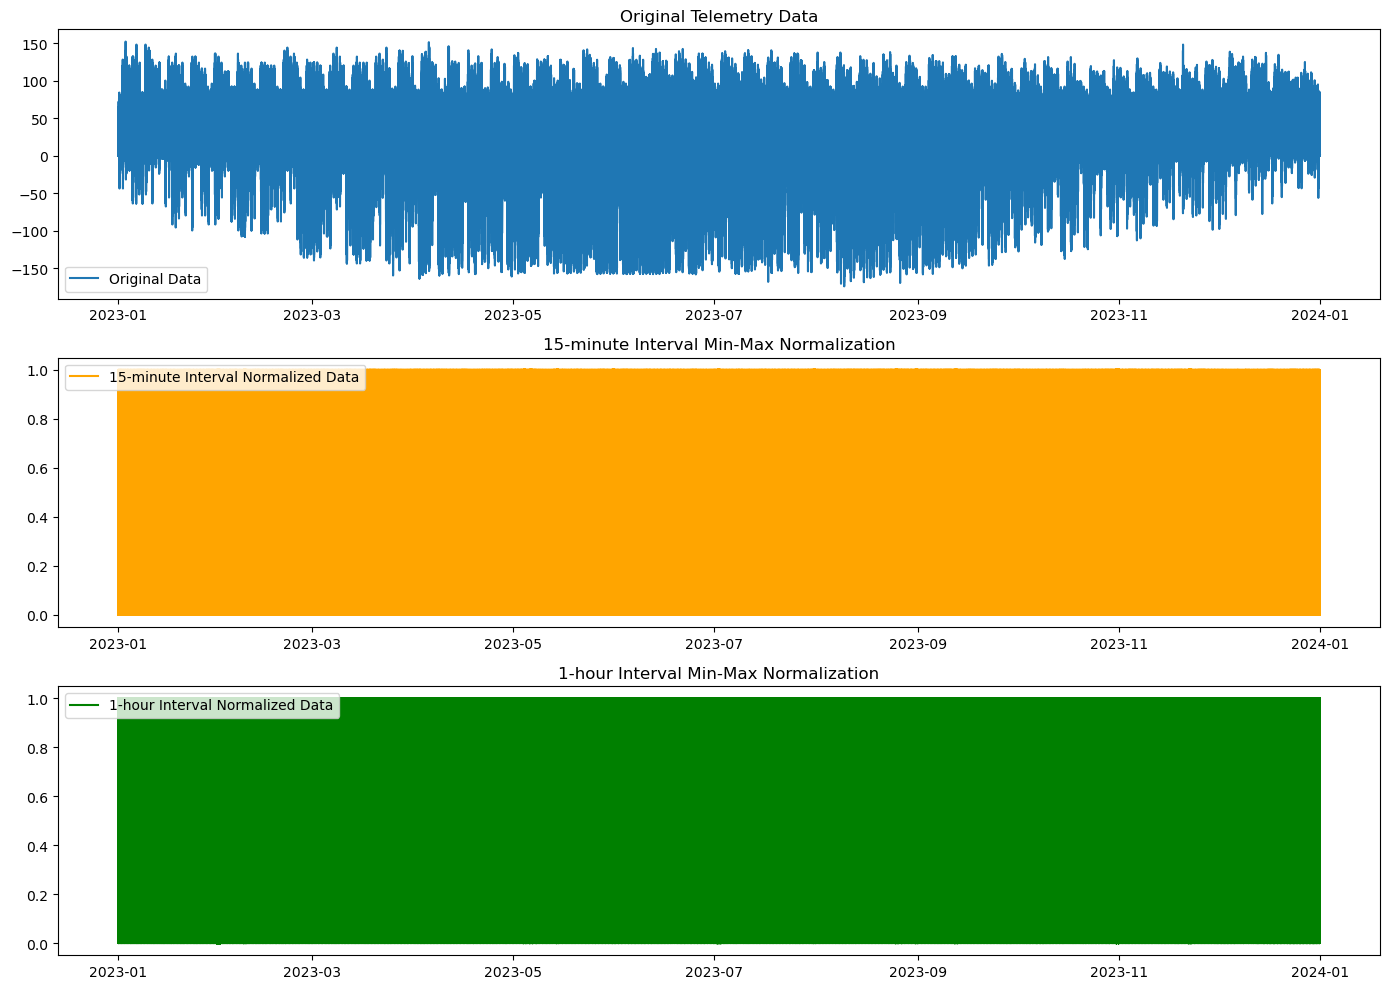

In [22]:

# Set the datetime column as the index
#selected_df.set_index('datetime', inplace=True)

# Function to apply Min-Max normalization
def min_max_normalize(df, interval):
    resampled_df = df.resample(interval).apply({'load': ['min', 'max']})
    normalized_data = []
    
    for start, end in zip(resampled_df.index[:-1], resampled_df.index[1:]):
        mask = (df.index >= start) & (df.index < end)
        interval_data = df[mask].copy()
        X_min = resampled_df.loc[start, ('load', 'min')]
        X_max = resampled_df.loc[start, ('load', 'max')]
        interval_data['normalized_load'] = (interval_data['load'] - X_min) / (X_max - X_min)
        normalized_data.append(interval_data)
    
    normalized_df = pd.concat(normalized_data)
    return normalized_df

# Normalize for 15-minute intervals
normalized_df_15_min = min_max_normalize(selected_df, '15T')

# Normalize for 1-hour intervals
normalized_df_1_hour = min_max_normalize(selected_df, '1H')

# Display the results
print("Original Data:")
print(selected_df)
print("\nNormalized Data (15-minute intervals):")
print(normalized_df_15_min)
print("\nNormalized Data (1-hour intervals):")
print(normalized_df_1_hour)

# Visualization
plt.figure(figsize=(14, 10))

# Original data plot
plt.subplot(3, 1, 1)
plt.plot(selected_df.index, selected_df['load'], label='Original Data')
plt.title('Original Telemetry Data')
plt.legend()

# 15-minute interval normalization plot
plt.subplot(3, 1, 2)
plt.plot(normalized_df_15_min.index, normalized_df_15_min['normalized_load'], label='15-minute Interval Normalized Data', color='orange')
plt.title('15-minute Interval Min-Max Normalization')
plt.legend()

# 1-hour interval normalization plot
plt.subplot(3, 1, 3)
plt.plot(normalized_df_1_hour.index, normalized_df_1_hour['normalized_load'], label='1-hour Interval Normalized Data', color='green')
plt.title('1-hour Interval Min-Max Normalization')
plt.legend()

plt.tight_layout()
plt.show()


#  Rolling Window Normalization

Overview:
This technique involves computing normalization statistics (e.g., min, max, mean, standard deviation) over a rolling window of recent data points. The window size can be adjusted based on the expected variability and the frequency of peaks in your data.

Steps:

1. Select Window Size: Determine the number of recent data points to include in each window.
2. Compute Statistics: For each window, compute the necessary statistics (e.g., min, max, mean, standard deviation).
3. Normalize: Apply normalization based on the computed statistics for each window.

Given that your data is recorded in 15-minute intervals, you might start by considering window sizes that align with meaningful time intervals, such as 1 hour (window size of 4) or 4 hours (window size of 16). 

C:\Users\20236192\AppData\Local\Temp\ipykernel_22812\3094131579.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['normalized_load'] = rolling_window_normalize(selected_df, window_size)


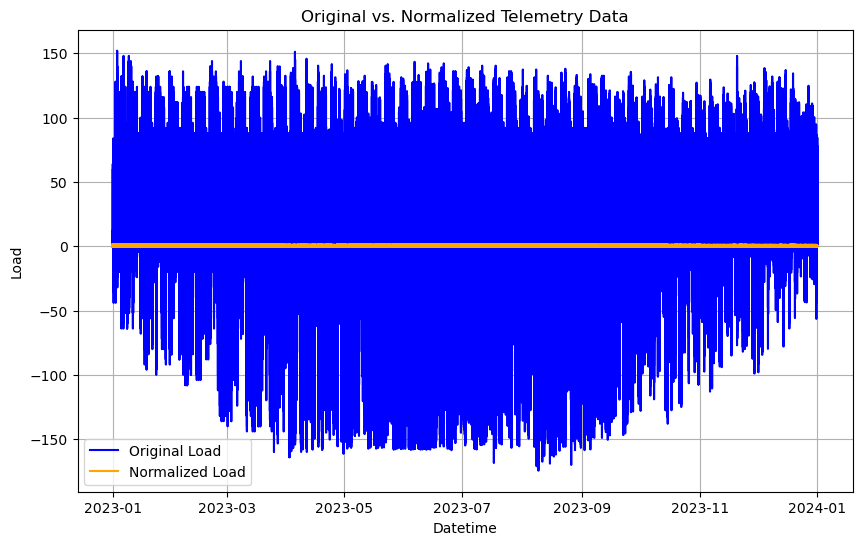

In [23]:
# Function to perform rolling window normalization
def rolling_window_normalize(df, window_size):
    rolling_min = df['load'].rolling(window=window_size, min_periods=1).min()
    rolling_max = df['load'].rolling(window=window_size, min_periods=1).max()
    normalized_data = (df['load'] - rolling_min) / (rolling_max - rolling_min)
    return normalized_data

# Set the window size for rolling window normalization
window_size = 4  # Example window size, adjust as needed  16  # 4 hours for 15-minute interval data

# Apply rolling window normalization to your DataFrame
selected_df['normalized_load'] = rolling_window_normalize(selected_df, window_size)

import matplotlib.pyplot as plt

# Plotting the original and normalized data
plt.figure(figsize=(10, 6))

# Original data
plt.plot(selected_df.index, selected_df['load'], label='Original Load', color='blue')

# Normalized data
plt.plot(selected_df.index, selected_df['normalized_load'], label='Normalized Load', color='orange')

plt.title('Original vs. Normalized Telemetry Data')
plt.xlabel('Datetime')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
 selected_df['normalized_load']

datetime
2023-01-01 00:00:00         NaN
2023-01-01 00:00:00    0.000000
2023-01-01 00:00:00    0.000000
2023-01-01 00:00:00    1.000000
2023-01-01 00:00:00    0.000000
                         ...   
2023-12-31 23:45:00    0.000000
2023-12-31 23:45:00    0.114655
2023-12-31 23:45:00    0.313131
2023-12-31 23:45:00    1.000000
2023-12-31 23:45:00    0.000000
Name: normalized_load, Length: 4309920, dtype: float64

C:\Users\20236192\AppData\Local\Temp\ipykernel_22812\1323082902.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_df['normalized_load'] = rolling_window_normalize(customer_df, window_size)


                     RND_ID  load  normalized_load
datetime                                          
2023-01-01 00:00:00    1179  12.0              NaN
2023-01-01 00:15:00    1179   8.0         0.000000
2023-01-01 00:30:00    1179  12.0         1.000000
2023-01-01 00:45:00    1179   8.0         0.000000
2023-01-01 01:00:00    1179  12.0         1.000000
...                     ...   ...              ...
2023-12-31 22:45:00    1179  11.4         0.335196
2023-12-31 23:00:00    1179  12.0         0.504202
2023-12-31 23:15:00    1179  10.8         0.000000
2023-12-31 23:30:00    1179  10.8         0.000000
2023-12-31 23:45:00    1179  11.4         0.500000

[35040 rows x 3 columns]


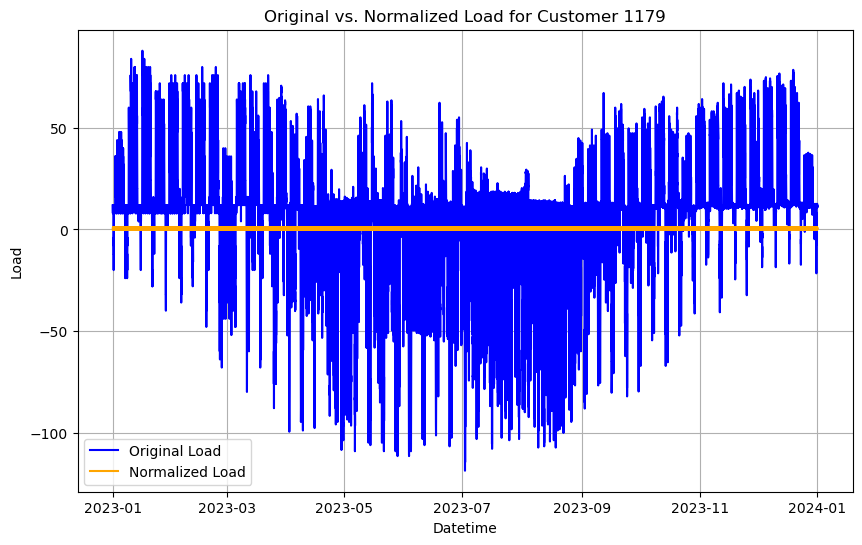

In [29]:
 # Filter for a specific customer, e.g., RND_ID == 1
customer_id = 1179
customer_df = selected_df[selected_df['RND_ID'] == customer_id]

# Function to perform rolling window normalization
def rolling_window_normalize(df, window_size):
    rolling_min = df['load'].rolling(window=window_size, min_periods=1).min()
    rolling_max = df['load'].rolling(window=window_size, min_periods=1).max()
    normalized_data = (df['load'] - rolling_min) / (rolling_max - rolling_min)
    return normalized_data

# Set the window size for rolling window normalization
window_size = 4  # Example window size, adjust as needed

# Apply rolling window normalization to the customer's data
customer_df['normalized_load'] = rolling_window_normalize(customer_df, window_size)

# Display the resulting DataFrame
print(customer_df)

# Visualization
plt.figure(figsize=(10, 6))

# Original data
plt.plot(customer_df.index, customer_df['load'], label='Original Load', color='blue')

# Normalized data
plt.plot(customer_df.index, customer_df['normalized_load'], label='Normalized Load', color='orange')

plt.title(f'Original vs. Normalized Load for Customer {customer_id}')
plt.xlabel('Datetime')
plt.ylabel('Load')
plt.legend()
plt.grid(True)
plt.show()


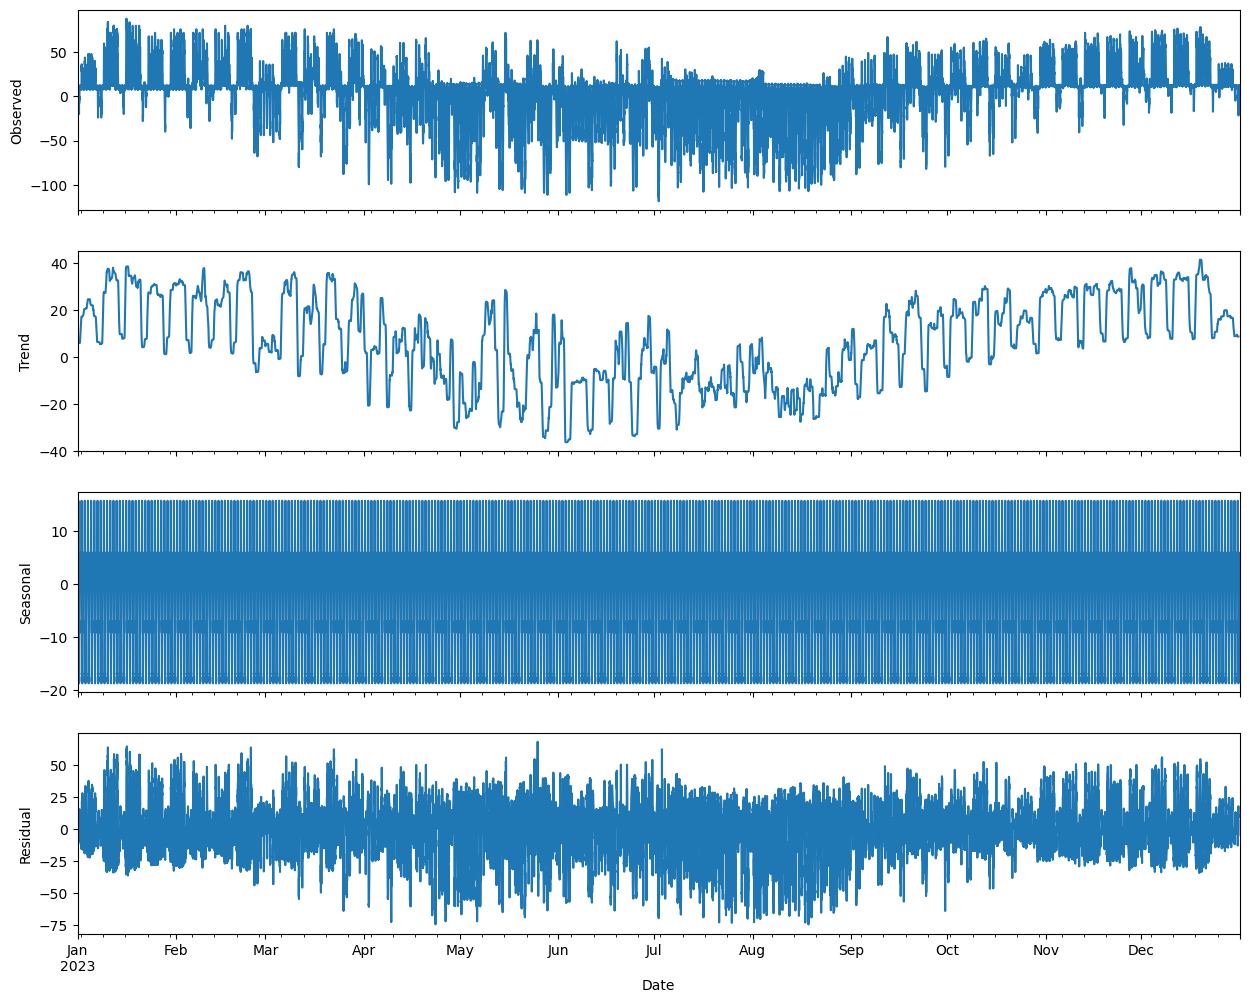

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming selected_df is your DataFrame
# Ensure 'datetime' column is converted to datetime type and set as index
#selected_df['datetime'] = pd.to_datetime(selected_df['datetime'])
#selected_df.set_index('datetime', inplace=True)

# Check the data for a specific customer
customer_id = 1179  # Example customer ID
customer_data = selected_df[selected_df['RND_ID'] == customer_id]

# Perform seasonal decomposition
# Note: Frequency is set to 96 (4*24) for 15-minute intervals to capture daily seasonality
result = seasonal_decompose(customer_data['load'], model='additive', period=96)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.set_xlabel('Date')

plt.show()


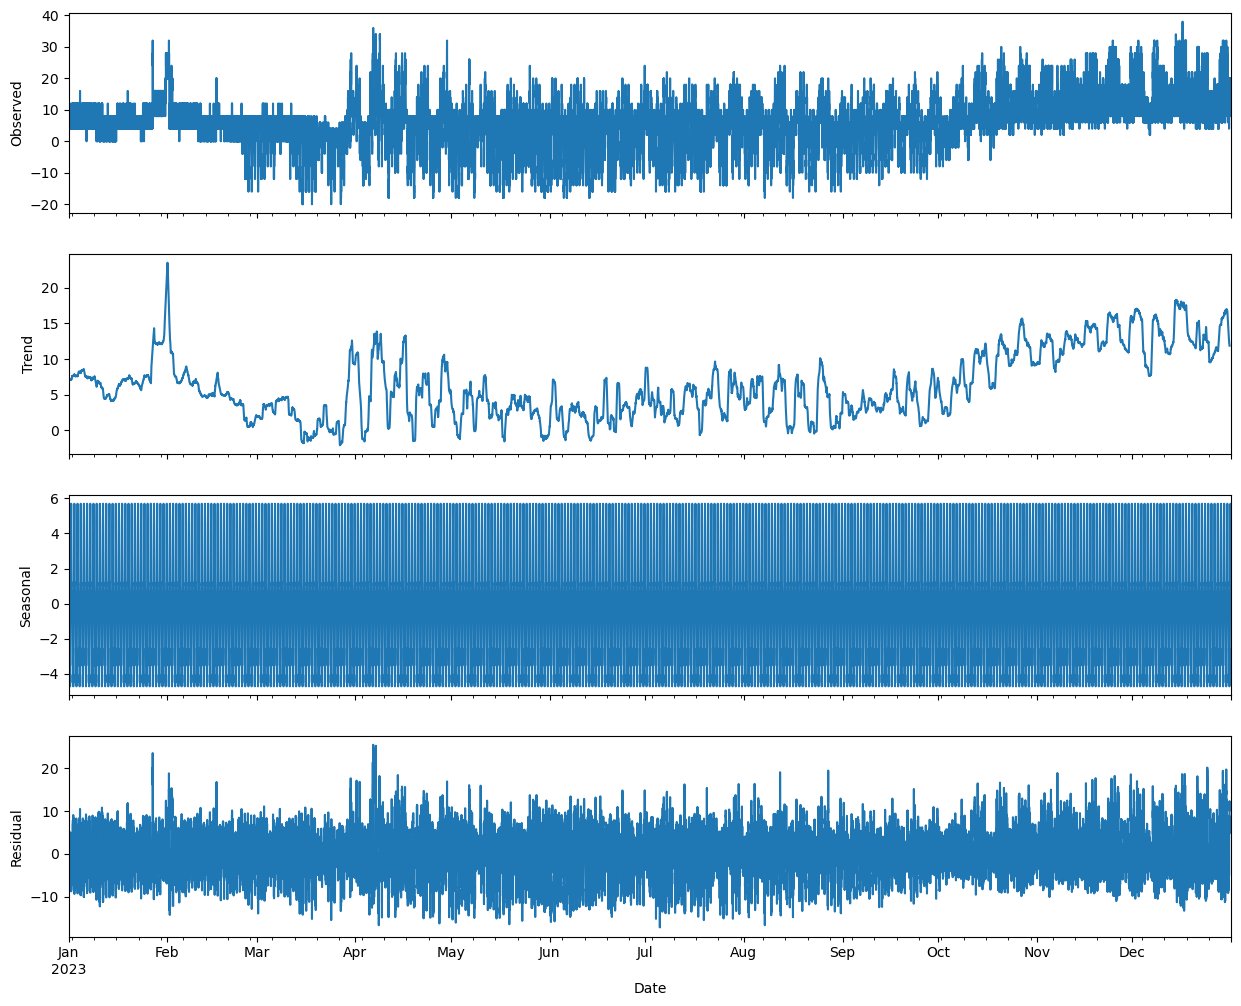

In [33]:
# Check the data for a specific customer
customer_id = 8531 # Example customer ID
customer_data = selected_df[selected_df['RND_ID'] == customer_id]

# Perform seasonal decomposition
# Note: Frequency is set to 96 (4*24) for 15-minute intervals to capture daily seasonality
result = seasonal_decompose(customer_data['load'], model='additive', period=96)

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.set_xlabel('Date')

plt.show()
